# Import

In [1]:
from Floquet_perturbation_theory import *
from qutip import *
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
import xarray as xr
from scipy.optimize import fsolve
from tqdm.notebook import tqdm
from helper_function import *

from sympy.physics.quantum import Dagger
from sympy.physics.quantum.boson import BosonOp
from sympy.physics.quantum.operatorordering import normal_ordered_form

Here, we start with the transmon-coupler-transmon architecture Hamiltonian
$$
\begin{gathered}
    H = \sum_{i=1,2} 4 E_{C_i} n_i^2 - E_{J_i} \cos(\phi_i) + 4 E_{C_c} n_c^2 - E_{J_\Sigma} \sqrt{\cos^2(\phi_\text{ext})+d^2\sin(\phi_\text{ext})^2} \cos(\phi_c) \\
    + g_{1c} n_1 n_c + g_{2c} n_2 n_c + g_{12} n_1 n_2
\end{gathered}
$$
with $d=\frac{E_{Jc_1}-E_{Jc_2}}{E_{Jc_1}+E_{Jc_2}}$ and $E_{J_\Sigma}=E_{Jc_1}+E_{Jc_2}$

Aiming for a parametric two-qubit gate, we implement a small periodic modulation of external flux, i.e., $\phi_{\text{ext}}=\delta \cos(\omega_d t)$ and want to rewrite the Hamiltonian abover using sympy expamsions.

<img src="Figure/CircuitDiagram.png" width="800">

# Effective Form of the cQED Hamiltonian

we start from Taylor expansions of the coupler transmon Hamiltonian, aiming at obtaining an effective form of the circuit model with separation in static and time-modulating part for perturbation theory

In [2]:
phi_ext = sp.symbols("\\phi_{ext}")
EJSigma = sp.symbols("E_{J\\Sigma}")
d = sp.symbols("d")

squid = EJSigma * sp.sqrt((sp.cos(phi_ext)) ** 2 + d**2 * (sp.sin(phi_ext)) ** 2)
squid

E_{J\Sigma}*sqrt(d**2*sin(\phi_{ext})**2 + cos(\phi_{ext})**2)

We consider the simplest case where the flux bias point is at symmetry point, i.e., $\phi_{ext}=\delta \cos(\omega_d t)$. When the bias is not 0, there will be multiple frequencies of the drive.

By replacing the external flux of squid Hamiltonian to a perodic modulations

In [3]:
delta = sp.symbols("\\delta")
wd = sp.symbols("\\omega_{d}")
t = sp.symbols("t")

squid_modulated = squid.subs({phi_ext: delta * sp.cos(wd * t)})
squid_modulated

E_{J\Sigma}*sqrt(d**2*sin(\delta*cos(\omega_{d}*t))**2 + cos(\delta*cos(\omega_{d}*t))**2)

Then we can do Taylor expansion and collect the terms in the power of small modulation $\delta$

In [4]:
ejc_expansion = squid_modulated.series(delta, 0, 3).removeO()
ejc_simplified = sp.fu(ejc_expansion)
ejc_collected = sp.collect(ejc_simplified, delta * sp.cos(wd * t))
ejc_collected

E_{J\Sigma}*\delta**2*(d**2*cos(\omega_{d}*t)**2/2 - cos(\omega_{d}*t)**2/2) + E_{J\Sigma}

By ignoring the energy shift of the Hamiltonian, it looks like
$$
\begin{gathered}
    H = \sum_{i=1,2} 4 E_{C_i} n_i^2 - E_{J_i} \cos(\phi_i) + 4 E_{C_c} n_c^2 - E_{J_\Sigma} \cos(\phi_c) \left(1+\frac{d^2-1}{2}\cos(\omega_d t)^2\right) \\
    + g_{1c} n_1 n_c + g_{2c} n_2 n_c + g_{12} n_1 n_2
\end{gathered}
$$
Now we want to implement the second quantization to really write the Hamiltonian in terms of creation and destroy operators.

In [5]:
# The definitions of non-commuting operators should be different from trivial variables.
# Otherwise, SymPy will treat them as commuting variables and give wrong results when we do algebraic manipulation.

a1 = BosonOp("a_1")
ad1 = Dagger(a1)
a2 = BosonOp("a_2")
ad2 = Dagger(a2)
ac = BosonOp("a_c")
adc = Dagger(ac)

# Define the symbols for the parameters in the Hamiltonian
EC1, EC2, ECc = sp.symbols("E_{C1}, E_{C2}, E_{Cc}")
EJ1, EJ2, EJc = sp.symbols("E_{J1}, E_{J2}, E_{Jc}")
g1c, g2c, g12 = sp.symbols("g_{1c}, g_{2c}, g_{12}")

# Let's first keep the charge and phase operators, and later we can express them in terms of ladder operators if needed.
n1, n2, nc = sp.symbols("n_1, n_2, n_c")
phi1, phi2, phic = sp.symbols("\\phi_1, \\phi_2, \\phi_c")

# Thus the coupled Hamiltonian can be written as:
Hamiltonian = (
    4 * EC1 * n1**2
    - EJ1 * sp.cos(phi1)
    + 4 * EC2 * n2**2
    - EJ2 * sp.cos(phi2)
    + 4 * ECc * nc**2
    - EJc * sp.cos(phic)
    + g1c * n1 * nc
    + g2c * n2 * nc
    + g12 * n1 * n2
)

Now we insert the expression of modulated Josephson energy of the coupler

In [6]:
Hamiltonian_expanded = Hamiltonian.subs({EJc: ejc_collected})
Hamiltonian_expanded

4*E_{C1}*n_1**2 + 4*E_{C2}*n_2**2 + 4*E_{Cc}*n_c**2 - E_{J1}*cos(\phi_1) - E_{J2}*cos(\phi_2) + g_{12}*n_1*n_2 + g_{1c}*n_1*n_c + g_{2c}*n_2*n_c - (E_{J\Sigma}*\delta**2*(d**2*cos(\omega_{d}*t)**2/2 - cos(\omega_{d}*t)**2/2) + E_{J\Sigma})*cos(\phi_c)

We apply the Taylor expansions of the cos-terms to address the anharmonicity of the each transmon

In [ ]:
# we have to go to the fourth order expansion to get the anharmonic terms in each of the cos potential.
Hamiltonian_expanded = sp.series(Hamiltonian_expanded, phi1, 0, 4).removeO()
Hamiltonian_expanded = sp.series(Hamiltonian_expanded, phi2, 0, 4).removeO()
Hamiltonian_expanded = sp.series(Hamiltonian_expanded, phic, 0, 4).removeO()
Hamiltonian_expanded = sp.simplify(Hamiltonian_expanded)
Hamiltonian_expanded

4*E_{C1}*n_1**2 + 4*E_{C2}*n_2**2 + 4*E_{Cc}*n_c**2 - E_{J1}*\phi_1**4/24 + E_{J1}*\phi_1**2/2 - E_{J1} - E_{J2}*\phi_2**4/24 + E_{J2}*\phi_2**2/2 - E_{J2} - E_{J\Sigma}*\delta**2*(d**2 - 1)*cos(\omega_{d}*t)**2/2 + E_{J\Sigma}*\phi_c**4*(\delta**2*(1 - d**2)*cos(\omega_{d}*t)**2 - 2)/48 + E_{J\Sigma}*\phi_c**2*(\delta**2*(d**2 - 1)*cos(\omega_{d}*t)**2 + 2)/4 - E_{J\Sigma} + g_{12}*n_1*n_2 + g_{1c}*n_1*n_c + g_{2c}*n_2*n_c

Substituting the ladder operator expressions with 
$$
\begin{align}
\phi = \left(\frac{2E_C}{E_J}\right)^{\frac{1}{4}}(a+a^\dagger)\\
n = i\left(\frac{2E_J}{32E_C}\right)^{\frac{1}{4}}(a^\dagger-a)
\end{align}
$$
leads to

In [8]:
# Now substitute the ladder operator expressions into the expanded Hamiltonian
Hamiltonian_substituted = Hamiltonian_expanded.subs(
    {
        phi1: (2 * EC1 / EJ1) ** sp.Rational(1, 4) * (a1 + ad1),
        n1: sp.I * (EJ1 / (32 * EC1)) ** sp.Rational(1, 4) * (ad1 - a1),
        phi2: (2 * EC2 / EJ2) ** sp.Rational(1, 4) * (a2 + ad2),
        n2: sp.I * (EJ2 / (32 * EC2)) ** sp.Rational(1, 4) * (ad2 - a2),
        phic: (2 * ECc / EJSigma) ** sp.Rational(1, 4) * (ac + adc),
        nc: sp.I * (EJSigma / (32 * ECc)) ** sp.Rational(1, 4) * (adc - ac),
    }
)

# Expand algebraically (respects noncommutativity)
Hamiltonian_expanded_second = Hamiltonian_substituted.expand()

Hamiltonian_expanded_second

sqrt(2)*E_{C1}*sqrt(E_{J1}/E_{C1})*Dagger(a_1)*a_1/2 - sqrt(2)*E_{C1}*sqrt(E_{J1}/E_{C1})*Dagger(a_1)**2/2 + sqrt(2)*E_{C1}*sqrt(E_{J1}/E_{C1})*a_1*Dagger(a_1)/2 - sqrt(2)*E_{C1}*sqrt(E_{J1}/E_{C1})*a_1**2/2 - E_{C1}*Dagger(a_1)*a_1*Dagger(a_1)*a_1/12 - E_{C1}*Dagger(a_1)*a_1*Dagger(a_1)**2/12 - E_{C1}*Dagger(a_1)*a_1**2*Dagger(a_1)/12 - E_{C1}*Dagger(a_1)*a_1**3/12 - E_{C1}*Dagger(a_1)**2*a_1*Dagger(a_1)/12 - E_{C1}*Dagger(a_1)**2*a_1**2/12 - E_{C1}*Dagger(a_1)**3*a_1/12 - E_{C1}*Dagger(a_1)**4/12 - E_{C1}*a_1*Dagger(a_1)*a_1*Dagger(a_1)/12 - E_{C1}*a_1*Dagger(a_1)*a_1**2/12 - E_{C1}*a_1*Dagger(a_1)**2*a_1/12 - E_{C1}*a_1*Dagger(a_1)**3/12 - E_{C1}*a_1**2*Dagger(a_1)*a_1/12 - E_{C1}*a_1**2*Dagger(a_1)**2/12 - E_{C1}*a_1**3*Dagger(a_1)/12 - E_{C1}*a_1**4/12 + sqrt(2)*E_{C2}*sqrt(E_{J2}/E_{C2})*Dagger(a_2)*a_2/2 - sqrt(2)*E_{C2}*sqrt(E_{J2}/E_{C2})*Dagger(a_2)**2/2 + sqrt(2)*E_{C2}*sqrt(E_{J2}/E_{C2})*a_2*Dagger(a_2)/2 - sqrt(2)*E_{C2}*sqrt(E_{J2}/E_{C2})*a_2**2/2 - E_{C2}*Dagger(a_2)*a

To simplify the expressions, it's better to enforce it in normal order (all creation operators to the left), and simplify with commutation relations of bosonic operators

In [9]:
Hamiltonian_expanded_second = normal_ordered_form(
    Hamiltonian_expanded_second, independent=True
)

# Further simplify the expression by combining like terms and applying power simplification
Hamiltonian_expanded_second = sp.powdenest(Hamiltonian_expanded_second, force=True)

# Collect terms by absorbing the same powers of variables into a simgle term
Hamiltonian_expanded_second = sp.powsimp(Hamiltonian_expanded_second, force=True)

# Get the energy offset by substituting all ladder operators to zero (vacuum expectation value)
constant = Hamiltonian_expanded_second.subs(
    {a1: 0, a2: 0, ac: 0, ad1: 0, ad2: 0, adc: 0}
)

# Subtract the constant from the Hamiltonian to set the ground state energy to zero
Hamiltonian_expanded_second = Hamiltonian_expanded_second - constant

# Collect terms in the order of physcial parameters for better readability
Hamiltonian_expanded_sort = sp.collect(
    Hamiltonian_expanded_second, [delta * sp.cos(wd * t), g12, g1c, g2c]
)

For better readability, we replace the collection of multiplication to the number operator and implement the hardcore approximation(setting energy non-conserving parts to be 0)

In [11]:
N1, N2, Nc = sp.symbols("N_1, N_2, N_c")

Hamiltonian_expanded_sort = Hamiltonian_expanded_sort.subs(
    {
        Dagger(a1) * a1: N1,
        Dagger(a2) * a2: N2,
        Dagger(ac) * ac: Nc,
    }
)

Hamiltonian_expanded_hardcore = HardCore(Hamiltonian_expanded_sort, a1, a2, ac)

In [12]:
# Print the static qubit, coupler as well as static coupling of the Hamiltonian by substituting the interaction terms to zero.
print("The first qubit part of the Hamiltonian is: ")
display(
    sp.collect(
        Hamiltonian_expanded_hardcore.subs({N2: 0, Nc: 0, g12: 0, g1c: 0, g2c: 0}), [N1]
    )
)
print("The second qubit part of the Hamiltonian is: ")
display(
    sp.collect(
        Hamiltonian_expanded_hardcore.subs({N1: 0, Nc: 0, g12: 0, g1c: 0, g2c: 0}), [N2]
    )
)
print("The coupler part of the Hamiltonian is: ")
display(
    sp.collect(
        Hamiltonian_expanded_hardcore.subs({N1: 0, N2: 0, g12: 0, g1c: 0, g2c: 0}), [Nc]
    )
)
print("The coupling part of the Hamiltonian is: ")
display(
    sp.simplify(
        sp.collect(
            Hamiltonian_expanded_hardcore.subs({N1: 0, N2: 0, Nc: 0, g1c: 0, g2c: 0}),
            [g12],
        )
    )
    + sp.simplify(
        sp.collect(
            Hamiltonian_expanded_hardcore.subs({N1: 0, N2: 0, Nc: 0, g12: 0, g2c: 0}),
            [g1c],
        )
    )
    + sp.simplify(
        sp.collect(
            Hamiltonian_expanded_hardcore.subs({N1: 0, N2: 0, Nc: 0, g12: 0, g1c: 0}),
            [g2c],
        )
    )
)

The first qubit part of the Hamiltonian is: 


-E_{C1}*N_1**2/2 + N_1*(-E_{C1} + 2*sqrt(2)*sqrt(E_{C1}*E_{J1}))

The second qubit part of the Hamiltonian is: 


-E_{C2}*N_2**2/2 + N_2*(-E_{C2} + 2*sqrt(2)*sqrt(E_{C2}*E_{J2}))

The coupler part of the Hamiltonian is: 


-E_{Cc}*N_c**2/2 + N_c*(-E_{Cc} + 2*sqrt(2)*sqrt(E_{Cc}*E_{J\Sigma})) + \delta**2*(N_c**2*(-E_{Cc}*d**2/4 + E_{Cc}/4) + N_c*(-E_{Cc}*d**2/2 + E_{Cc}/2 + sqrt(2)*d**2*sqrt(E_{Cc}*E_{J\Sigma})/2 - sqrt(2)*sqrt(E_{Cc}*E_{J\Sigma})/2))*cos(\omega_{d}*t)**2

The coupling part of the Hamiltonian is: 


sqrt(2)*g_{12}*(E_{J1}*E_{J2})**(1/4)*(-Dagger(a_1)*Dagger(a_2) + Dagger(a_1)*a_2 - a_1*a_2 + Dagger(a_2)*a_1)/(8*(E_{C1}*E_{C2})**(1/4)) + sqrt(2)*g_{1c}*(E_{J1}*E_{J\Sigma})**(1/4)*(-Dagger(a_1)*Dagger(a_c) + Dagger(a_1)*a_c - a_1*a_c + Dagger(a_c)*a_1)/(8*(E_{C1}*E_{Cc})**(1/4)) + sqrt(2)*g_{2c}*(E_{J2}*E_{J\Sigma})**(1/4)*(-Dagger(a_2)*Dagger(a_c) + Dagger(a_2)*a_c - a_2*a_c + Dagger(a_c)*a_2)/(8*(E_{C2}*E_{Cc})**(1/4))

Though here I only include the symmetric case, one can easily assume a nonzero bias point and omit the changes in the code to compute as higher order contributions as possible.

# Initial Setup of System

After knowing the the explicit form of the Hamiltonian, we first demonstrating the typical process of rabi coupling and stark shifts from defining an algebaric expression of energy spectrum, static coupling and the first harmonics. By choosing the frequency
$$
\omega_d \approx \omega_2 - \omega_1
$$,
we aim for a iswap-type process between two qubit states.

In [15]:
# we use the typical operators to indicate the non-zero matrix elements between the states of interest.
dim_q1 = 3
dim_q2 = 3
dim_c = 3

w1, w2, wc, alpha1, alpha2, alphac, g1c, g2c, g12 = sp.symbols(
    "\\omega_1, \\omega_2, \\omega_c, \\alpha_1, \\alpha_2, \\alpha_c, g_{1c}, g_{2c}, g_{12}",
    real=True,
)

a_q1 = tensor(destroy(dim_q1), qeye(dim_c), qeye(dim_q2))
a_q2 = tensor(qeye(dim_q1), qeye(dim_c), destroy(dim_q2))
a_qc = tensor(qeye(dim_q1), destroy(dim_c), qeye(dim_q2))

E = np.diag(
    w1 * (a_q1.dag() @ a_q1).full()
    + alpha1 / 2 * (a_q1.dag() @ a_q1.dag() @ a_q1 @ a_q1).full()
    + w2 * (a_q2.dag() @ a_q2).full()
    + alpha2 / 2 * (a_q2.dag() @ a_q2.dag() @ a_q2 @ a_q2).full()
    + wc * (a_qc.dag() @ a_qc).full()
    + alphac / 2 * (a_qc.dag() @ a_qc.dag() @ a_qc @ a_qc).full()
)

V0 = (
    g1c * ((a_q1 - a_q1.dag()) @ (a_qc - a_qc.dag())).full()
    + g2c * ((a_q2 - a_q2.dag()) @ (a_qc - a_qc.dag())).full()
    + g12 * ((a_q1 - a_q1.dag()) @ (a_q2 - a_q2.dag())).full()
)

V1 = delta * (a_qc.dag() @ a_qc).full()

Depending on the non-zero matrix elements of E, V0 and V1, we define the correponding analytical form of those matrices.

In [16]:
D = dim_q1 * dim_c * dim_q2

## Analytics 3 levels using sympy
E_analytics = np.zeros(D, dtype=sy.Symbol)
for n1 in range(dim_q1):
    for nc in range(dim_c):
        for n2 in range(dim_q2):
            n = n1 * dim_c * dim_q2 + nc * dim_q2 + n2
            E_analytics[n] = sy.symbols(f"E_{{\\ket{{{n1}{nc}{n2}}}}}", real=True)

## Non-zero matrix elements of static coupling V0 and drive coupling V1
V0_analytics = np.zeros((D, D), dtype=sy.Symbol)
V1_analytics = np.zeros((D, D), dtype=sy.Symbol)
for i1 in range(dim_q1):
    for i2 in range(dim_q2):
        for ic in range(dim_c):
            for jc in range(dim_c):
                for j1 in range(dim_q1):
                    for j2 in range(dim_q2):
                        i = i1 * dim_c * dim_q2 + ic * dim_q2 + i2
                        j = j1 * dim_c * dim_q2 + jc * dim_q2 + j2
                        if V0[i, j] != 0:
                            V0_analytics[i, j] = sy.symbols(
                                f"\\bra{{{i1}{ic}{i2}}}V_0{{\\ket{{{j1}{jc}{j2}}}}}"
                            )
                        if V1[i, j] != 0:
                            V1_analytics[i, j] = sy.symbols(
                                f"\\bra{{{i1}{ic}{i2}}}V_1{{\\ket{{{j1}{jc}{j2}}}}}"
                            )

# Identifying the Resonant Condition

## Rabi rate

explaination here

In [17]:
state_a = dim_q2 * dim_c  # state |100>
state_b = 1  # state |001>

wd = sp.symbols("\\omega_{d}", real=True)

In [18]:
Heff_Floquet_summed(
    3,
    state_b,
    state_a,
    wd,
    {state_a: 1, state_b: 0},  # E_state_a - wd = E_state_b
    E_analytics,
    V1_analytics,
    V0_analytics,
    analytics=True,
)

\bra{001}V_0{\ket{010}}*\bra{010}V_0{\ket{100}}*conjugate(\bra{010}V_1{\ket{010}})/((E_{\ket{001}} - E_{\ket{010}})*(E_{\ket{001}} - E_{\ket{010}} + \omega_{d})) + \bra{001}V_0{\ket{111}}*\bra{111}V_0{\ket{100}}*conjugate(\bra{111}V_1{\ket{111}})/((E_{\ket{001}} - E_{\ket{111}})*(E_{\ket{001}} - E_{\ket{111}} + \omega_{d}))

From the anlaytical expression, we know that the population transferring is happening in two paths by the 3rd order process.

- 001 -> 010 -> 010 -> 100
- 001 -> 111 -> 111 -> 100

The processes consist of parametric modulation of middle coupler frequency as well as pairwise swapping and creation.

In [19]:
Heff_Floquet(
    3,
    state_b,
    state_a,
    wd,
    {state_a: 1, state_b: 0},  # E_state_a - wd = E_state_b
    E,
    V1,
    V0,
)

1.0*g_{1c}*g_{2c}*conjugate(\delta)/((1.0*\omega_2 - 1.0*\omega_c)*(1.0*\omega_2 - 1.0*\omega_c + \omega_{d})) + 1.0*g_{1c}*g_{2c}*conjugate(\delta)/((-1.0*\omega_1 - 1.0*\omega_c)*(-1.0*\omega_1 - 1.0*\omega_c + \omega_{d}))

Thus, we could have a function that returns the rabi rates of the swapping rate between two states of intersts.

In [20]:
def rabi_rate(fre, amp, order, i, f, E0, V0, V1, analytics=False):
    rabi = Heff_Floquet_summed(
        order,
        i,
        f,
        fre,
        {i: 1, f: 0},  # E_i - wd = E_f
        E0,
        amp / 2 * V1,
        V0=V0,
        analytics=analytics,
    )
    return rabi

## Stark shift

Similarly, we could understand which processes contribute in the stark shifts of two states. This is particularly important since in the Floquet picture, only two states degenerate hybridized and lead to populations transfer.

In [21]:
Heff_Floquet(
    2,
    state_a,
    state_a,
    wd,
    {state_a: 1, state_b: 0},  # E_state_a - wd = E_state_b
    E_analytics,
    V1_analytics,
    V0_analytics,
    analytics=True,
)

re(\bra{100}V_0{\ket{210}}*\bra{210}V_0{\ket{100}})/(E_{\ket{001}} - E_{\ket{210}} + \omega_{d}) + re(\bra{100}V_0{\ket{201}}*\bra{201}V_0{\ket{100}})/(E_{\ket{001}} - E_{\ket{201}} + \omega_{d}) + re(\bra{100}V_0{\ket{111}}*\bra{111}V_0{\ket{100}})/(E_{\ket{001}} - E_{\ket{111}} + \omega_{d}) + re(\bra{010}V_0{\ket{100}}*\bra{100}V_0{\ket{010}})/(E_{\ket{001}} - E_{\ket{010}} + \omega_{d}) + re(\bra{001}V_0{\ket{100}}*\bra{100}V_0{\ket{001}})/\omega_{d}

In [22]:
Heff_Floquet(
    2,
    state_b,
    state_b,
    wd,
    {state_a: 1, state_b: 0},  # E_state_a - wd = E_state_b
    E_analytics,
    V1_analytics,
    V0_analytics,
    analytics=True,
)

re(\bra{001}V_0{\ket{111}}*\bra{111}V_0{\ket{001}})/(E_{\ket{001}} - E_{\ket{111}}) + re(\bra{001}V_0{\ket{102}}*\bra{102}V_0{\ket{001}})/(E_{\ket{001}} - E_{\ket{102}}) + re(\bra{001}V_0{\ket{012}}*\bra{012}V_0{\ket{001}})/(E_{\ket{001}} - E_{\ket{012}}) + re(\bra{001}V_0{\ket{010}}*\bra{010}V_0{\ket{001}})/(E_{\ket{001}} - E_{\ket{010}}) - re(\bra{001}V_0{\ket{100}}*\bra{100}V_0{\ket{001}})/\omega_{d}

When plugging in the formula we derived before, we have

In [23]:
Heff_Floquet(
    2,
    state_a,
    state_a,
    wd,
    {state_a: 1, state_b: 0},  # E_state_a - wd = E_state_b
    E,
    V1,
    V0,
)

2.0*g_{12}**2/(-1.0*\alpha_1 - 2.0*\omega_1 + \omega_{d}) + 2.0*g_{1c}**2/(-1.0*\alpha_1 - 2.0*\omega_1 + 1.0*\omega_2 - 1.0*\omega_c + \omega_{d}) + 1.0*g_{1c}**2/(1.0*\omega_2 - 1.0*\omega_c + \omega_{d}) + 1.0*g_{2c}**2/(-1.0*\omega_1 - 1.0*\omega_c + \omega_{d}) + 1.0*g_{12}**2/\omega_{d}

In [24]:
def resonant_condition(fre, amp, order, i, f, E0, V0, V1, analytics=False):
    Heff_ii = Heff_Floquet_summed(
        order,
        i,
        i,
        fre,
        {i: 1, f: 0},  # E_i - wd = E_f
        E0,
        amp / 2 * V1,
        V0=V0,
        analytics=analytics,
    )
    Heff_ff = Heff_Floquet_summed(
        order,
        f,
        f,
        fre,
        {i: 1, f: 0},  # E_i - wd = E_f
        E0,
        amp / 2 * V1,
        V0=V0,
        analytics=analytics,
    )
    diff = Heff_ff - Heff_ii
    return diff

# Numerical Searching for Resonant Dynamics

However, in the real setup, the wavefunction of single qubit is no longle localized but in its dressed basis. Thus, computing the swapping rate in the dressed basis is of importance. Thus, when in the real case, we always first numerically diagonalize the system and reexpress operators in the dressed basis. 

In that way, we utilize a real setup of transmon coupler system to simulate the iswap gate.

In [3]:
w1 = 3.83 * 2 * np.pi  # GHz
alpha1 = -0.205 * 2 * np.pi  # GHz
w2 = 3.11 * 2 * np.pi  # GHz
alpha2 = -0.216 * 2 * np.pi  # GHz
wc = 4.29 * 2 * np.pi  # GHz
alphac = -0.161 * 2 * np.pi  # GHz

g1c = 0.115 * 2 * np.pi  # GHz
g2c = 0.110 * 2 * np.pi  # GHz
g12 = 0.015 * 2 * np.pi  # GHz

From the parameters, we define the Hamiltonian in terms of qutip, which we will later use for dynamical simulations.

In [4]:
dim_q1 = 3
dim_q2 = 3
dim_c = 3

a_q1 = tensor(destroy(dim_q1), qeye(dim_c), qeye(dim_q2))
a_q2 = tensor(qeye(dim_q1), qeye(dim_c), destroy(dim_q2))
a_qc = tensor(qeye(dim_q1), destroy(dim_c), qeye(dim_q2))

H_q1 = w1 * a_q1.dag() @ a_q1 + (alpha1 / 2) * a_q1.dag() @ a_q1.dag() @ a_q1 @ a_q1
H_q2 = w2 * a_q2.dag() @ a_q2 + (alpha2 / 2) * a_q2.dag() @ a_q2.dag() @ a_q2 @ a_q2
H_c = wc * a_qc.dag() @ a_qc + (alphac / 2) * a_qc.dag() @ a_qc.dag() @ a_qc @ a_qc

V_0 = (
    g1c * ((a_q1 - a_q1.dag()) @ (a_qc - a_qc.dag()))
    + g2c * ((a_q2 - a_q2.dag()) @ (a_qc - a_qc.dag()))
    + g12 * ((a_q1 - a_q1.dag()) @ (a_q2 - a_q2.dag()))
)
V_1 = a_qc.dag() @ a_qc

From the Hamiltonian, we go to the dressed basis by finding the eigenstates and transformation matrix U.

In [5]:
evals, evecs = (H_q1 + H_q2 + H_c + V_0).eigenstates()
sorted_evals, sorted_evecs = SortedFRFSpectrum(evals, evecs, dim_q1, dim_c, dim_q2)

# transformation matrix from bare basis to dressed basis
U = Qobj(
    np.column_stack(
        [
            sorted_evecs[i, j, k].full()
            for i in range(dim_q1)
            for j in range(dim_c)
            for k in range(dim_q2)
        ]
    ),
    dims=[[dim_q1, dim_c, dim_q2], [dim_q1, dim_c, dim_q2]],
)

H0_dressed = U.dag() @ (H_q1 + H_q2 + H_c + V_0) @ U
V1_dressed = U.dag() @ V_1 @ U
print(
    "Resonant Frequency (GHz): ",
    (sorted_evals[1, 0, 0] - sorted_evals[0, 0, 1]) / (2 * np.pi),
)

Resonant Frequency (GHz):  0.706336526689509


Also, the projectors are used to keep track of populations of different states we interested.

In [6]:
projection_100 = sorted_evecs[1, 0, 0] @ sorted_evecs[1, 0, 0].dag()
projection_010 = sorted_evecs[0, 1, 0] @ sorted_evecs[0, 1, 0].dag()
projection_001 = sorted_evecs[0, 0, 1] @ sorted_evecs[0, 0, 1].dag()
projection_111 = sorted_evecs[1, 1, 1] @ sorted_evecs[1, 1, 1].dag()

In [29]:
lwd = np.linspace(0.700, 0.712, 20) * 2 * np.pi
lA = np.linspace(0.001, 0.2, 20) * 2 * np.pi

mesh_wd, mesh_A = np.meshgrid(lwd, lA, indexing="ij")
final_pop_grid = np.zeros((len(lwd), len(lA)))

tlist = np.linspace(0, 200, 1000)

for i, wd in enumerate(tqdm(lwd)):
    for j, A in enumerate(lA):
        result = mesolve(
            [H_q1 + H_q2 + H_c + V_0, [V_1, lambda t, args: A * np.cos(wd * t)]],
            sorted_evecs[1, 0, 0],
            tlist,
            [],
            e_ops=[projection_001],
        )
        final_pop_grid[i, j] = result.expect[0][-1]

  0%|          | 0/20 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Population in |010> after 200 ns')

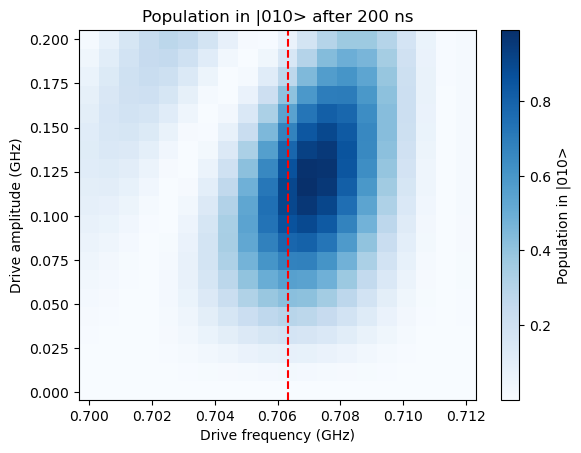

In [30]:
fig, ax = plt.subplots()
pcm = ax.pcolormesh(
    mesh_wd / (2 * np.pi),
    mesh_A / (2 * np.pi),
    final_pop_grid,
    shading="auto",
    rasterized=True,
    cmap="Blues",
)
fig.colorbar(pcm, ax=ax, label="Population in |010>")
ax.axvline(
    (sorted_evals[1, 0, 0] - sorted_evals[0, 0, 1]) / (2 * np.pi),
    color="red",
    linestyle="--",
    label="Transition frequency",
)
ax.set_xlabel("Drive frequency (GHz)")
ax.set_ylabel("Drive amplitude (GHz)")
ax.set_title("Population in |010> after 200 ns")

# Check the Resonant Condition and Population Transfer Rate

In [10]:
E_num = sorted_evals.reshape(dim_q1 * dim_c * dim_q2)
V1_num = (
    V1_dressed.full().reshape(dim_q1 * dim_c * dim_q2, dim_q1 * dim_c * dim_q2).real
)

state_a = dim_c * dim_q2  # state |100> corresponds to index 16
state_b = 1  # state |001> corresponds to index 4

In [56]:
lresonant_wd_order2 = np.zeros_like(lA)
for j, A in enumerate(tqdm(lA)):
    wd_initial_guess = 2 * np.pi * 0.705
    resonant_wd_solution = fsolve(
        resonant_condition,
        wd_initial_guess,
        args=(A, 2, state_a, state_b, E_num, None, V1_num),
    )
    lresonant_wd_order2[j] = resonant_wd_solution[0]

  0%|          | 0/20 [00:00<?, ?it/s]

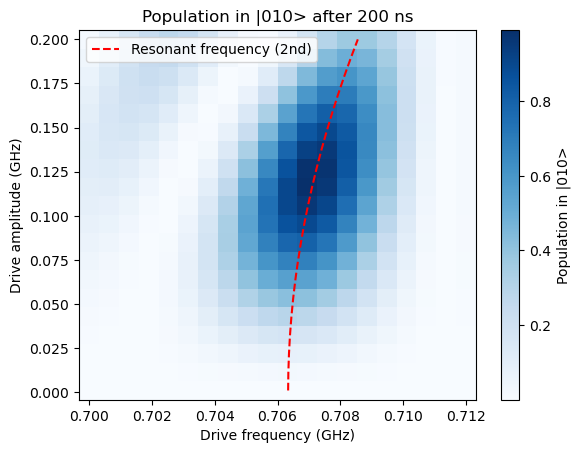

In [58]:
fig, ax = plt.subplots()
pcm = ax.pcolormesh(
    mesh_wd / (2 * np.pi),
    mesh_A / (2 * np.pi),
    final_pop_grid,
    shading="auto",
    rasterized=True,
    cmap="Blues",
)
fig.colorbar(pcm, ax=ax, label="Population in |010>")
ax.plot(
    lresonant_wd_order2 / (2 * np.pi),
    lA / (2 * np.pi),
    ls="--",
    color="red",
    label="Resonant frequency (2nd)",
)
ax.set_xlabel("Drive frequency (GHz)")
ax.set_ylabel("Drive amplitude (GHz)")
ax.set_title("Population in |010> after 200 ns")
ax.legend()

In [59]:
lresonant_rabi_order2 = np.zeros_like(lA)

for index in range(len(lA)):
    resonant_frequency = lresonant_wd_order2[index]
    amp = lA[index]
    rabi = rabi_rate(
        resonant_frequency,
        amp,
        2,
        state_b,
        state_a,
        E_num,
        V0=None,
        V1=V1_num,
    )
    lresonant_rabi_order2[index] = np.abs(rabi)

In [22]:
# Evolution along the resonant frequency and drive amplitude
lpop_resonant = np.zeros_like(lA)

tlist = np.linspace(0, 200, 1000)
for i in range(len(lA)):
    amp = lA[i]
    fre = lresonant_wd_order2[i]
    result = mesolve(
        [H_q1 + H_q2 + H_c + V_0, [V_1, lambda t, args: amp * np.cos(fre * t)]],
        sorted_evecs[1, 0, 0],
        tlist,
        [],
        e_ops=[projection_001],
    )
    lpop_resonant[i] = result.expect[0][-1]

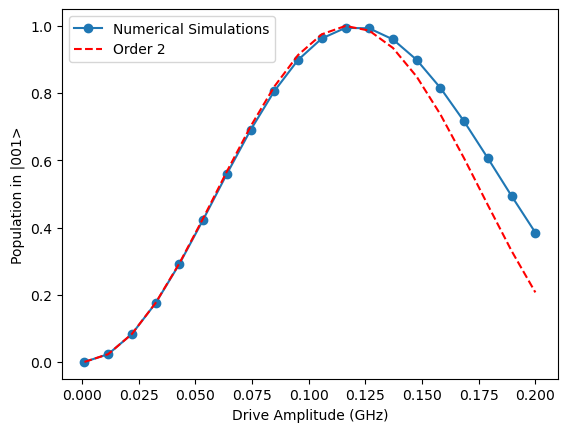

In [23]:
fig, ax = plt.subplots()
ax.plot(lA / (2 * np.pi), lpop_resonant, marker="o", label="Numerical Simulations")
ax.plot(
    lA / (2 * np.pi),
    np.sin(np.array(lresonant_rabi_order2) * tlist[-1]) ** 2,
    color="red",
    linestyle="--",
    label="Order 2",
)
ax.set_xlabel("Drive Amplitude (GHz)")
ax.set_ylabel("Population in |001>")
ax.legend()

Can we mitigate the errros in large amplitudes by going to higher order?

In [63]:
order = 3
lresonant_wd_order3 = np.zeros_like(lA)
lresonant_rabi_order3 = np.zeros_like(lA)

for j, A in enumerate(tqdm(lA)):
    wd_initial_guess = 2 * np.pi * 0.705
    resonant_wd_solution = fsolve(
        resonant_condition,
        wd_initial_guess,
        args=(A, order, state_a, state_b, E_num, None, V1_num),
    )
    lresonant_wd_order3[j] = resonant_wd_solution[0]

    rabi = rabi_rate(
        resonant_wd_solution[0],
        A,
        order,
        state_b,
        state_a,
        E_num,
        V0=None,
        V1=V1_num,
    )
    lresonant_rabi_order3[j] = np.abs(rabi)

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
order = 4
lresonant_wd_order4 = np.zeros_like(lA)
lresonant_rabi_order4 = np.zeros_like(lA)

for j, A in enumerate(tqdm(lA)):
    wd_initial_guess = 2 * np.pi * 0.705
    resonant_wd_solution = fsolve(
        resonant_condition,
        wd_initial_guess,
        args=(A, order, state_a, state_b, E_num, None, V1_num),
    )
    lresonant_wd_order4[j] = resonant_wd_solution[0]

    rabi = rabi_rate(
        resonant_wd_solution[0],
        A,
        order,
        state_b,
        state_a,
        E_num,
        V0=None,
        V1=V1_num,
    )
    lresonant_rabi_order4[j] = np.abs(rabi)

  0%|          | 0/20 [00:00<?, ?it/s]

In [66]:
ds = xr.Dataset(
    {
        "resonant_frequency_order_2": (("drive_amplitude"), lresonant_wd_order3),
        "resonant_frequency_order_3": (("drive_amplitude"), lresonant_wd_order3),
        "resonant_frequency_order_4": (("drive_amplitude"), lresonant_wd_order4),
        "rabi_rate_order_2": (("drive_amplitude"), lresonant_rabi_order2),
        "rabi_rate_order_3": (("drive_amplitude"), lresonant_rabi_order3),
        "rabi_rate_order_4": (("drive_amplitude"), lresonant_rabi_order4),
    },
    coords={"drive_amplitude": lA},
)
ds.to_netcdf("resonant_frequency_and_rabi_rate.nc")

In [2]:
ds = xr.open_dataset("resonant_frequency_and_rabi_rate.nc")
lA = ds["drive_amplitude"].values
lresonant_wd_order2 = ds["resonant_frequency_order_2"].values
lresonant_wd_order3 = ds["resonant_frequency_order_3"].values
lresonant_wd_order4 = ds["resonant_frequency_order_4"].values
lresonant_rabi_order2 = ds["rabi_rate_order_2"].values
lresonant_rabi_order3 = ds["rabi_rate_order_3"].values
lresonant_rabi_order4 = ds["rabi_rate_order_4"].values

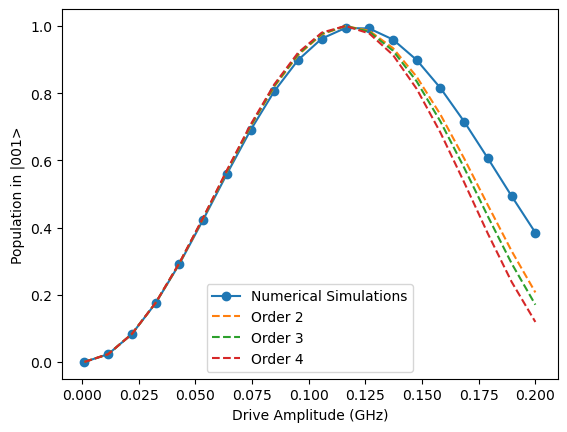

In [24]:
fig, ax = plt.subplots()
ax.plot(lA / (2 * np.pi), lpop_resonant, marker="o", label="Numerical Simulations")
ax.plot(
    lA / (2 * np.pi),
    np.sin(np.array(lresonant_rabi_order2) * tlist[-1]) ** 2,
    linestyle="--",
    label="Order 2",
)
ax.plot(
    lA / (2 * np.pi),
    np.sin(np.array(lresonant_rabi_order3) * tlist[-1]) ** 2,
    linestyle="--",
    label="Order 3",
)
ax.plot(
    lA / (2 * np.pi),
    np.sin(np.array(lresonant_rabi_order4) * tlist[-1]) ** 2,
    linestyle="--",
    label="Order 4",
)
ax.set_xlabel("Drive Amplitude (GHz)")
ax.set_ylabel("Population in |001>")
ax.legend()

Hmmm... It seems that increasing order in perturbation theory doesn't improve the result. There must be something missing when considering the process, which is the large leakage to $\ket{010}$ state when going to higher amplitudes.

# Improve Fidelities by Address the Fast Oscillations 

Now we test for the maximal drive amplitude and see the real-time evolutions to figure out what causes the imperfect predictions of the rabi rate.

In [34]:
test_fre = lresonant_wd_order2[-1]
test_amp = lA[-1]

test_tlist = np.linspace(0, 250, 2000)
test_dynamics = mesolve(
    [H_q1 + H_q2 + H_c + V_0, [V_1, lambda t, args: test_amp * np.cos(test_fre * t)]],
    sorted_evecs[1, 0, 0],
    test_tlist,
    [],
    e_ops=[projection_001, projection_100, projection_010, projection_111],
    options={"progress_bar": "tqdm"},
)

  0%|          | 0/1999 [00:00<?, ?it/s]

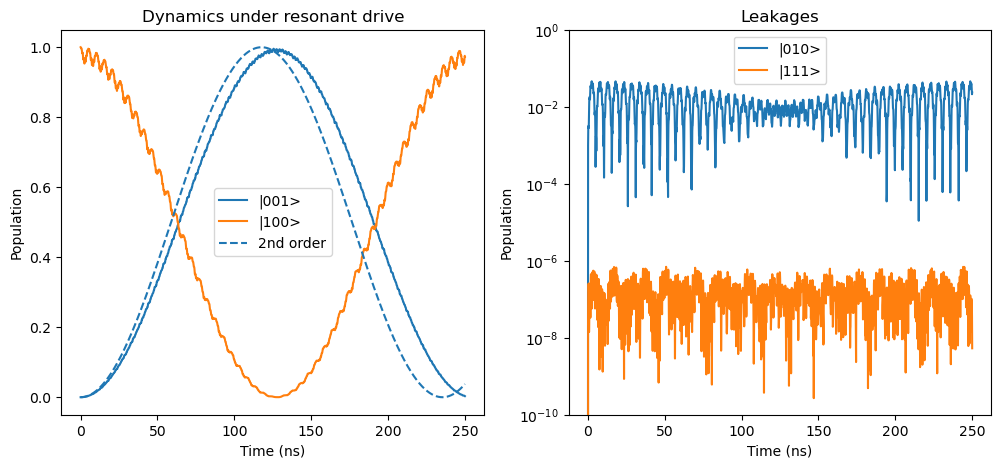

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(test_tlist, test_dynamics.expect[0], label="|001>")
ax[0].plot(test_tlist, test_dynamics.expect[1], label="|100>")
ax[0].plot(
    test_tlist,
    np.sin(np.array(lresonant_rabi_order2[-1]) * test_tlist) ** 2,
    ls="--",
    label="2nd order",
    color="C0",
)
ax[0].set_xlabel("Time (ns)")
ax[0].set_ylabel("Population")
ax[0].set_title("Dynamics under resonant drive")
ax[0].legend()

ax[1].plot(test_tlist, test_dynamics.expect[2], label="|010>")
ax[1].plot(test_tlist, test_dynamics.expect[3], label="|111>")
ax[1].set_ylim(1e-10, 1)
ax[1].set_xlabel("Time (ns)")
ax[1].set_ylabel("Population")
ax[1].set_title("Leakages")
ax[1].set_yscale("log")
ax[1].legend()

In [37]:
initial_state = np.zeros(dim_q1 * dim_c * dim_q2)
initial_state[state_a] = 1

state_c = dim_q2

In [47]:
rH = 2
rW = 0
psi_t_rHeff2_rW0 = Psi_t_FloquetPerturb(
    rH,
    rW,
    test_fre,
    test_amp,
    {state_a: 1, state_b: 0, state_c: 2},  # E_state_a - wd = E_state_b
    E_num,
    V1_num,
    initial_state,
    test_tlist,
)

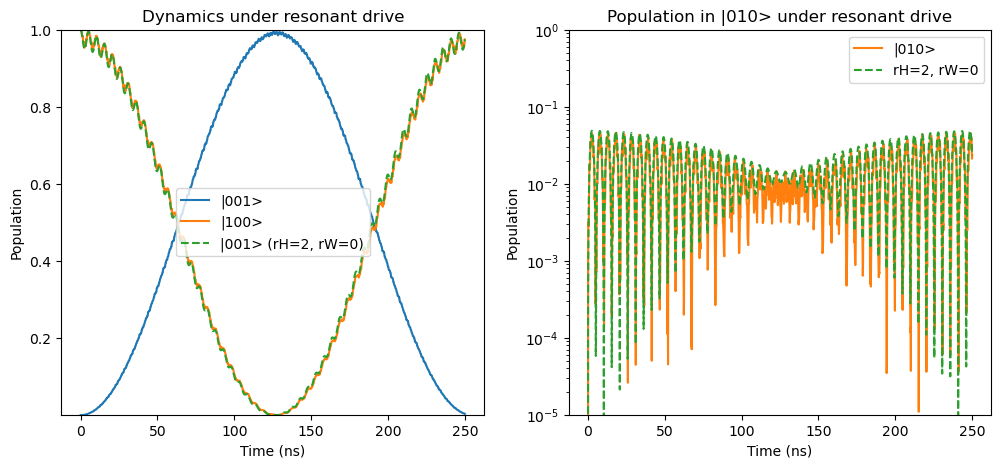

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(test_tlist, test_dynamics.expect[0], label="|001>")
ax[0].plot(test_tlist, test_dynamics.expect[1], label="|100>")
ax[0].plot(
    test_tlist,
    np.abs(psi_t_rHeff2_rW0[state_a, :]) ** 2,
    "--",
    label="|001> (rH=2, rW=0)",
)
ax[0].set_xlabel("Time (ns)")
ax[0].set_ylabel("Population")
ax[0].set_title("Dynamics under resonant drive")
ax[0].legend()
# ax[0].set_yscale("log")
ax[0].set_ylim(1e-3, 1)

# ax[1].plot(test_tlist, test_dynamics.expect[2], label="|010>")
ax[1].plot(test_tlist, test_dynamics.expect[2], label="|010>", color="C1")
ax[1].plot(
    test_tlist,
    np.abs(psi_t_rHeff2_rW0[state_c, :]) ** 2,
    "--",
    label="rH=2, rW=0",
    color="C2",
)
ax[1].set_ylim(1e-5, 1)
ax[1].set_xlabel("Time (ns)")
ax[1].set_ylabel("Population")
ax[1].set_title("Population in |010> under resonant drive")
ax[1].set_yscale("log")
ax[1].legend()

In [ ]:
lpop_order2 = np.zeros_like(lA)

for i in tqdm(range(len(lA))):
    amp = lA[i]
    fre = lresonant_wd_order2[i]
    psi_t = Psi_t_FloquetPerturb(
        2,
        0,
        fre,
        amp,
        {state_a: 1, state_b: 0, state_c: 2},  # E_state_a - wd = E_state_b
        E_num,
        V1_num,
        initial_state,
        tlist,
    )
    lpop_order2[i] = np.abs(psi_t[state_b, -1]) ** 2

  0%|          | 0/20 [00:00<?, ?it/s]

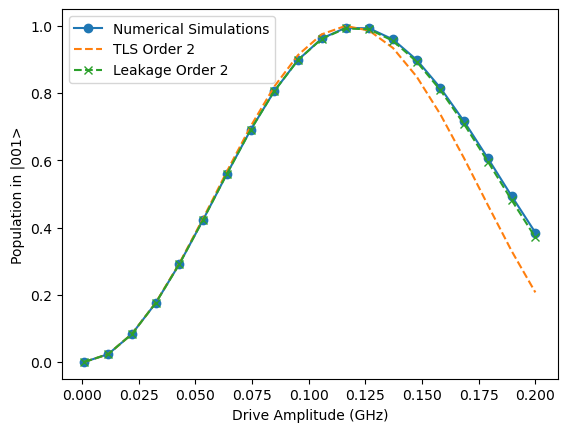

In [50]:
fig, ax = plt.subplots()
ax.plot(lA / (2 * np.pi), lpop_resonant, marker="o", label="Numerical Simulations")
ax.plot(
    lA / (2 * np.pi),
    np.sin(np.array(lresonant_rabi_order2) * tlist[-1]) ** 2,
    linestyle="--",
    label="TLS Order 2",
)
ax.plot(
    lA / (2 * np.pi),
    lpop_order2,
    marker="x",
    linestyle="--",
    label="Leakage Order 2",
)
ax.set_xlabel("Drive Amplitude (GHz)")
ax.set_ylabel("Population in |001>")
ax.legend()

In [44]:
lleakage1 = np.zeros_like(lA)
lleakage2 = np.zeros_like(lA)

for i in tqdm(range(len(lA))):
    fre = lresonant_wd_order2[i]
    amp = lA[i]

    matrix = Heff_Floquet_matrix_summed(
        2,
        fre,
        {state_a: 1, state_b: 0, state_c: 2},
        E_num,
        amp / 2 * V1_num,
        V0=None,
    )
    lleakage1[i] = np.abs(matrix[0, 2])
    lleakage2[i] = np.abs(matrix[1, 2])

  0%|          | 0/20 [00:00<?, ?it/s]

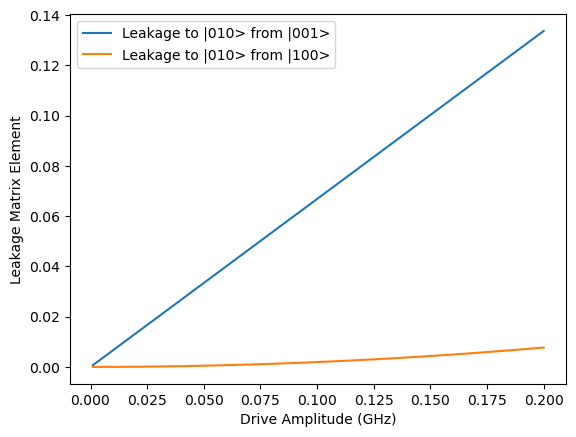

In [45]:
fig, ax = plt.subplots()
ax.plot(lA / (2 * np.pi), lleakage1, label="Leakage to |010> from |001>")
ax.plot(lA / (2 * np.pi), lleakage2, label="Leakage to |010> from |100>")
ax.set_xlabel("Drive Amplitude (GHz)")
ax.set_ylabel("Leakage Matrix Element")
ax.legend()

predictions overlappes in rabi rates

plot for fidelities

error from leakages and incorrect phases

task: how to improve